In [3]:
!pip install pandas numpy matplotlib pymc arviz


  Using cached pandas-2.3.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached numpy-2.3.2-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached matplotlib-3.10.5-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached pymc-5.25.1-py3-none-any.whl.metadata (16 kB)
  Using cached arviz-0.22.0-py3-none-any.whl.metadata (8.9 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.59.0-cp312-cp312-macosx_10_13_universal2.whl.metadata (107 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pillow-11.3.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached cachetools-6.1.0-py

In [9]:
!pip install seaborn


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from datetime import datetime

plt.style.use('ggplot')


In [3]:
# Load raw Brent oil prices CSV
df = pd.read_csv('../data/BrentOilPrices.csv')

# Check first few rows
df.head()

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


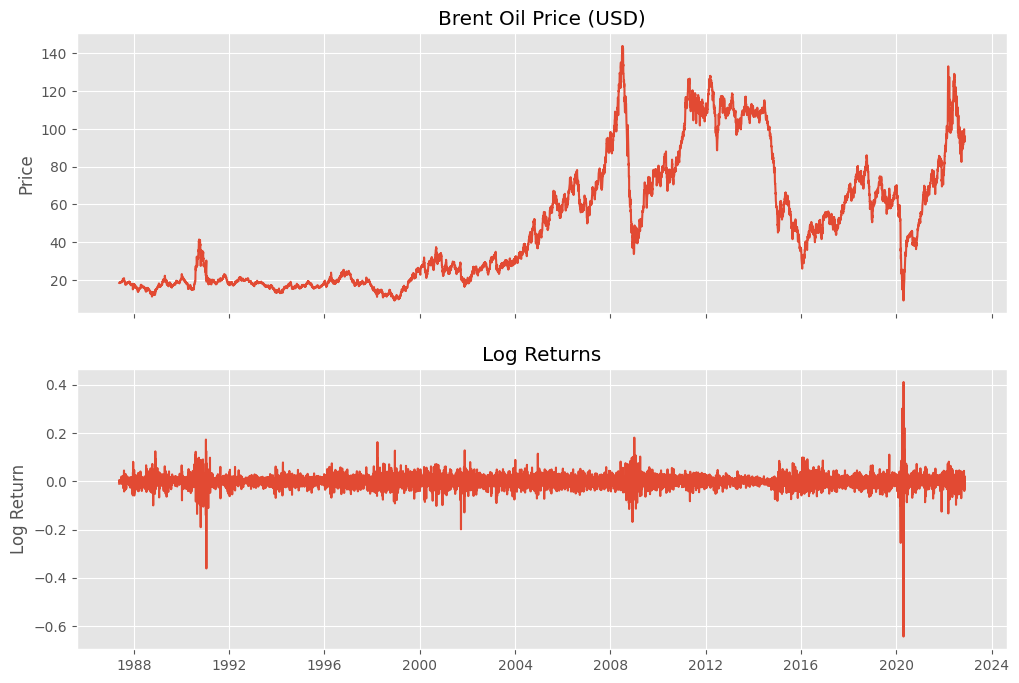

In [5]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True)

# Sort by date (just to be sure)
df = df.sort_values('Date')

# Calculate log returns: log(price_t) - log(price_{t-1})
df['log_return'] = np.log(df['Price']).diff()

# Drop NaN from diff()
df = df.dropna().reset_index(drop=True)

# Plot price and log returns
fig, axes = plt.subplots(2,1, figsize=(12,8), sharex=True)

axes[0].plot(df['Date'], df['Price'])
axes[0].set_title('Brent Oil Price (USD)')
axes[0].set_ylabel('Price')

axes[1].plot(df['Date'], df['log_return'])
axes[1].set_title('Log Returns')
axes[1].set_ylabel('Log Return')

plt.show()


In [6]:
# We model the log returns time series
returns = df['log_return'].values

# Number of observations
n = len(returns)


In [7]:
with pm.Model() as model:
    # Switch point prior: discrete uniform over all time points
    tau = pm.DiscreteUniform('tau', lower=0, upper=n-1)

    # Priors for means before and after change point
    mu1 = pm.Normal('mu1', mu=0, sigma=1)
    mu2 = pm.Normal('mu2', mu=0, sigma=1)

    # Priors for standard deviations before and after change point
    sigma1 = pm.HalfNormal('sigma1', sigma=1)
    sigma2 = pm.HalfNormal('sigma2', sigma=1)

    # Define mu and sigma using switch
    mu = pm.math.switch(tau >= np.arange(n), mu1, mu2)
    sigma = pm.math.switch(tau >= np.arange(n), sigma1, sigma2)

    # Likelihood
    returns_obs = pm.Normal('returns_obs', mu=mu, sigma=sigma, observed=returns)

    # Sample posterior
    trace = pm.sample(2000, tune=1000, target_accept=0.95, random_seed=42)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma1, sigma2]


/Users/tagesehandiso/miniforge3/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/tagesehandiso/miniforge3/lib/python3.12/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)
/Users/tagesehandiso/miniforge3/lib/python3.12/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)
/Users/tagesehandiso/miniforge3/lib/python3.12/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)
/Users/tagesehandiso/miniforge3/lib/python3.12/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.


            mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau     5387.495  21.23  5345.000  5420.000      0.696    0.465     970.0   
mu1        0.000   0.00    -0.000     0.001      0.000    0.000    9325.0   
mu2       -0.000   0.00    -0.001     0.001      0.000    0.000   10007.0   
sigma1     0.023   0.00     0.023     0.023      0.000    0.000   10472.0   
sigma2     0.029   0.00     0.028     0.030      0.000    0.000    9645.0   

        ess_tail  r_hat  
tau       1190.0    1.0  
mu1       5388.0    1.0  
mu2       5658.0    1.0  
sigma1    5763.0    1.0  
sigma2    6239.0    1.0  


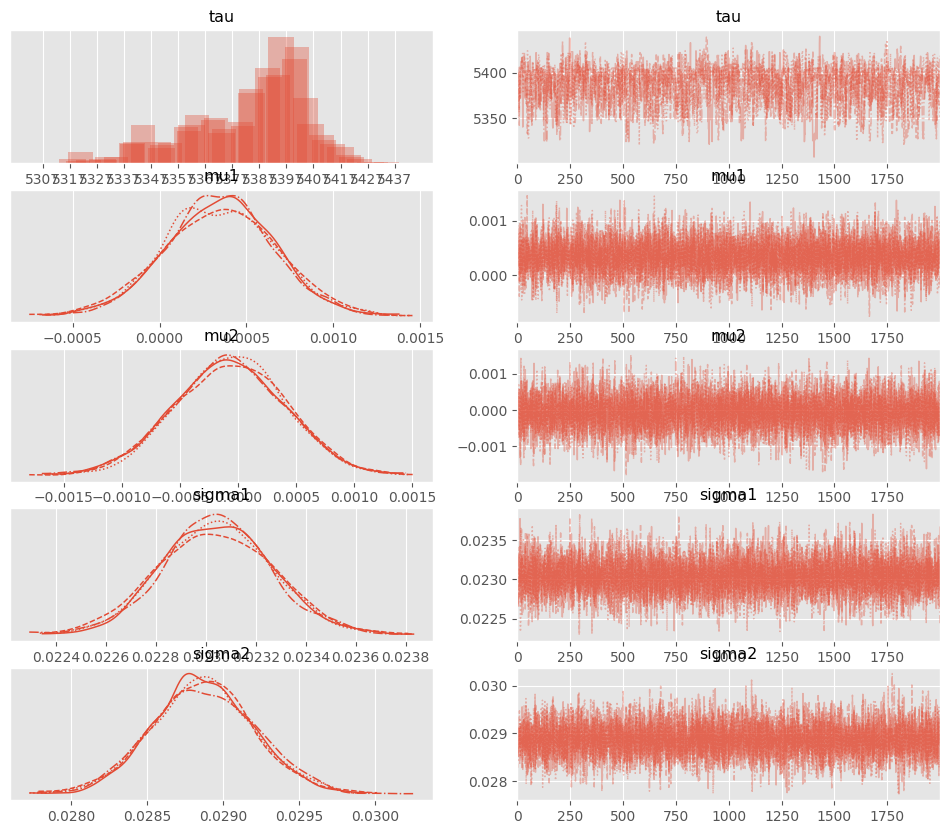

In [8]:
summary = az.summary(trace, var_names=['tau', 'mu1', 'mu2', 'sigma1', 'sigma2'])
print(summary)

# Trace plot
az.plot_trace(trace, var_names=['tau', 'mu1', 'mu2', 'sigma1', 'sigma2'])
plt.show()


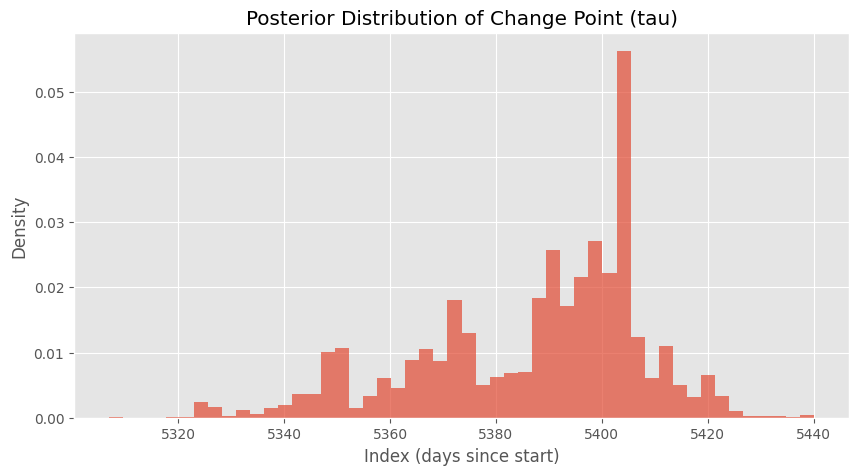

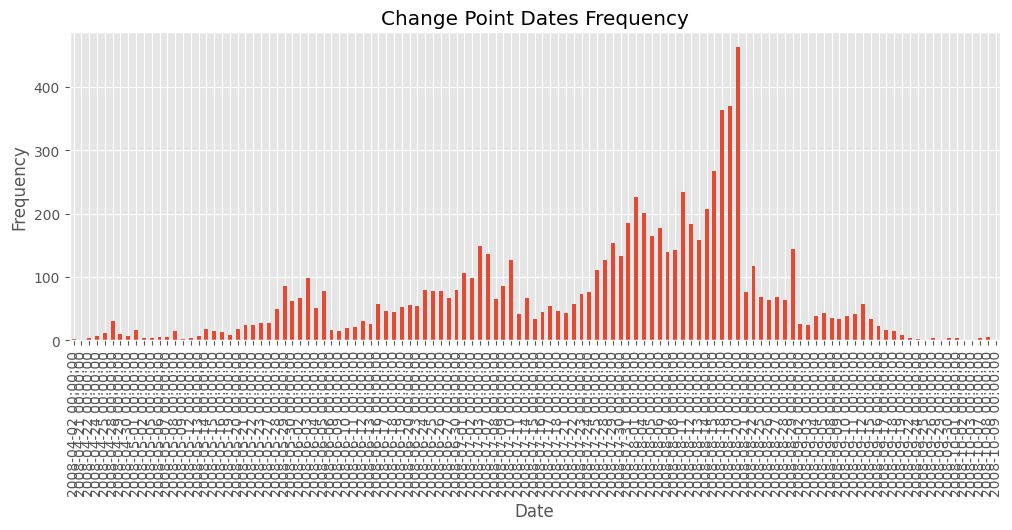

In [9]:
# Extract posterior samples of tau
tau_samples = trace.posterior['tau'].values.flatten()

# Plot posterior distribution of change point
plt.figure(figsize=(10,5))
plt.hist(tau_samples, bins=50, density=True, alpha=0.7)
plt.title('Posterior Distribution of Change Point (tau)')
plt.xlabel('Index (days since start)')
plt.ylabel('Density')
plt.show()

# Map tau to actual dates
tau_dates = df['Date'].iloc[tau_samples].value_counts().sort_index()
tau_dates.plot(kind='bar', figsize=(12,4))
plt.title('Change Point Dates Frequency')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.show()


In [10]:
# Posterior means of mu1 and mu2
mu1_post = trace.posterior['mu1'].mean().values
mu2_post = trace.posterior['mu2'].mean().values

print(f"Mean log return before change point: {mu1_post:.5f}")
print(f"Mean log return after change point: {mu2_post:.5f}")

# Convert back to price change percentages approximately
pct_change_before = (np.exp(mu1_post) - 1) * 100
pct_change_after = (np.exp(mu2_post) - 1) * 100

print(f"Approximate daily % change before: {pct_change_before:.2f}%")
print(f"Approximate daily % change after: {pct_change_after:.2f}%")


Mean log return before change point: 0.00034
Mean log return after change point: -0.00007
Approximate daily % change before: 0.03%
Approximate daily % change after: -0.01%


In [11]:
import pickle
import json

# Save trace (posterior samples)
with open('../models/trace_change_point.pkl', 'wb') as f:
    pickle.dump(trace, f)

# Save summary stats
summary_dict = summary.to_dict()
with open('../models/change_point_summary.json', 'w') as f:
    json.dump(summary_dict, f)
